# Remittances

## Packages

### Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from highlight_text import HighlightText, ax_text, fig_text

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [2]:
# Spanish
import locale
locale.setlocale(locale.LC_ALL, 'es_es')

'es_es'

### Customized functions

In [3]:
# Filter dataframe by date range or for two specific dates
def date_selection(data_frame,first_date,last_date,inbewtween):
    if inbewtween==True:
        data_frame = data_frame[(data_frame["date"] >= first_date) & (data_frame["date"] <= last_date)].reset_index(drop = True)
    else:
        data_frame = data_frame[(data_frame["date"] == first_date) | (data_frame["date"] == last_date)].reset_index(drop = True)
    return(data_frame)

# Return last date for any dataframe with a 'date' columns
def last_date(dataframe):
    x= dataframe['date'].tail(1).dt.strftime('%Y-%m-%d').to_string()[-10:]
    return(x)

## Data

### Payload

In [18]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "transaction_type"
    ],
    "categories": {
        "transaction_type": [
            "67ab6809f8707c4"
        ]
    },
    "request": [
        {
            "table": "mex_banxico_ce81",
            "variables": [
                "d89ce4905fe20e5",
                "30a32bc37839870"
            ]
        }
    ],
    "from": "2000-01-28"
}

response = get_tukan_api_request(payload)
data = response["data"]
data.tail(1)

Success getting the data


,date,transaction_type__ref,transaction_type,30a32bc37839870,d89ce4905fe20e5
264,2022-01-01,67ab6809f8707c4,Todas las transacciones,10589087.0,3.930815e+09


### Manipulation

In [32]:
remittances = data.copy()
remittances.rename(columns={'30a32bc37839870':'count','d89ce4905fe20e5':'amount'}, inplace=True)
# Average value
remittances['avg'] = remittances['amount'] / remittances['count']

# Yearly variation
remittances['yoy_count'] = remittances['count'].shift(12)
remittances['yoy_count'] = (remittances['count'] / remittances['yoy_count'])-1
remittances['yoy_amount'] = remittances['amount'].shift(12)
remittances['yoy_amount'] = (remittances['amount'] / remittances['yoy_amount'])-1
remittances['yoy_avg'] = remittances['avg'].shift(12)
remittances['yoy_avg'] = (remittances['avg'] / remittances['yoy_avg'])-1

# Values in millions
remittances['amount'] = remittances['amount'] / 1000000
remittances['count'] = remittances['count'] / 1000000
# remittances.tail(13)

## Level Plots

### Count

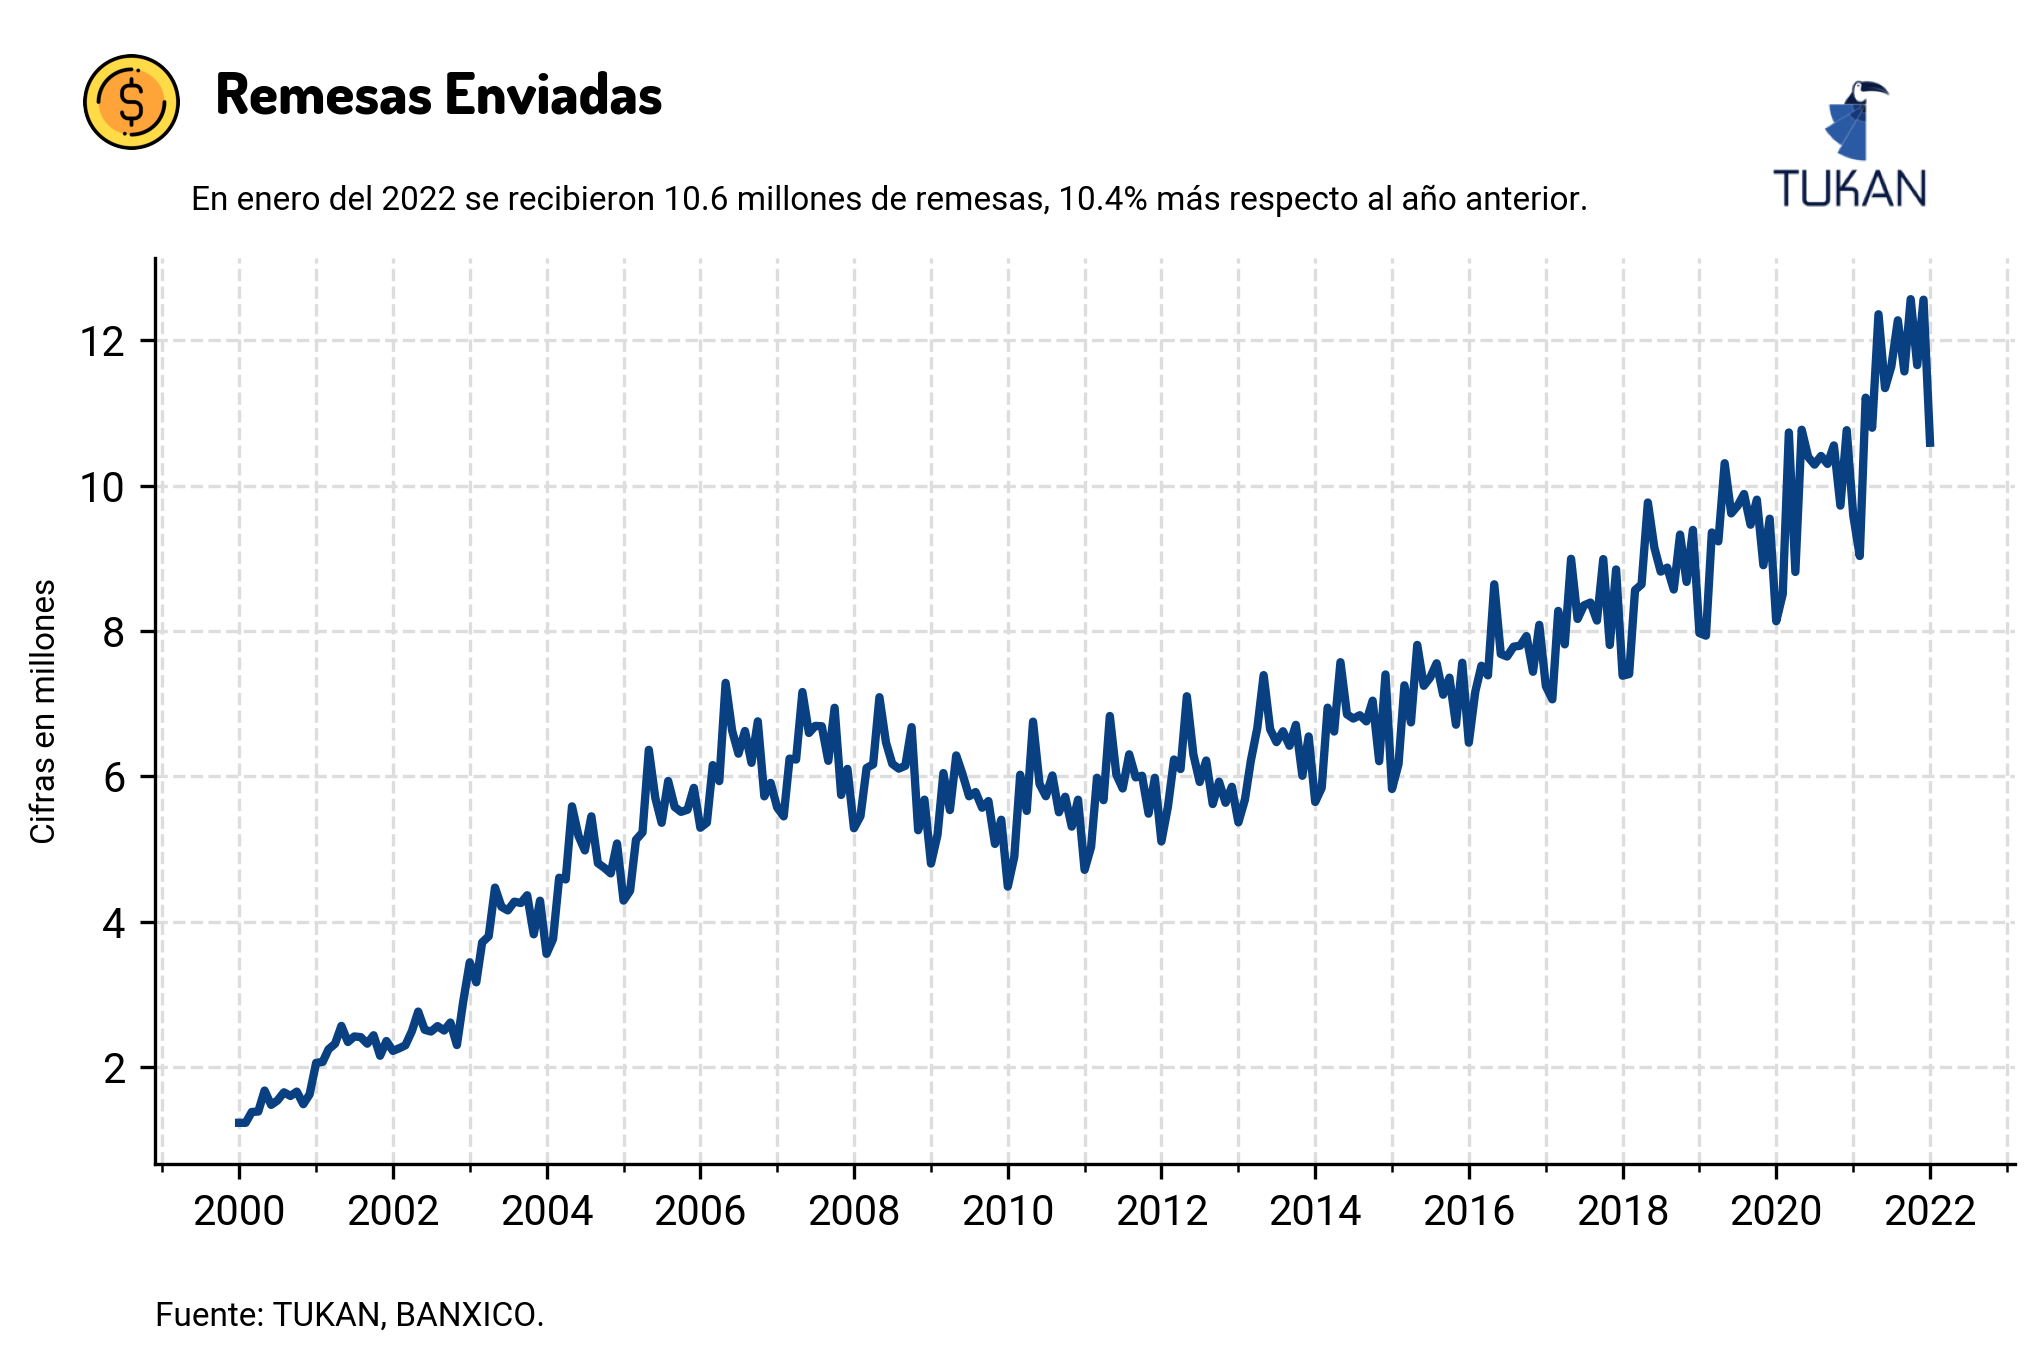

In [21]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(remittances["date"], remittances["count"], lw=2, zorder=3, color=cmap(0))
# ax.bar(remittances["date"], remittances["count"], zorder=2, width = 20, align='center', alpha=0.99, color=cmap(2))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylabel("Cifras en millones",
              size=8)
# ax.set_ylim(0)

# Icon
money_icon = image.imread("dollar.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = remittances['date'].tail(1).dt.strftime("%B del %Y").values[0]
last_value = remittances['count'].tail(1).values[0].round(1)
var_value = (remittances['yoy_count'].tail(1).values[0]*100).round(1)
if var_value < 0:
    var_dir = 'menos'
else:
    var_dir = 'más'

fig.text(
    0.15,
    1,
    "Remesas Enviadas",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.14,
    0.92,
    f"En {last_month} se recibieron {last_value} millones de remesas, {var_value}% {var_dir} respecto al año anterior.",
    size=8
)
# Add footer
fig.text(0.125, -0.01, "Fuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/remesas_cuenta_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/remesas_cuenta_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

plt.savefig(
    "plots/remesas_cuenta_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Amount

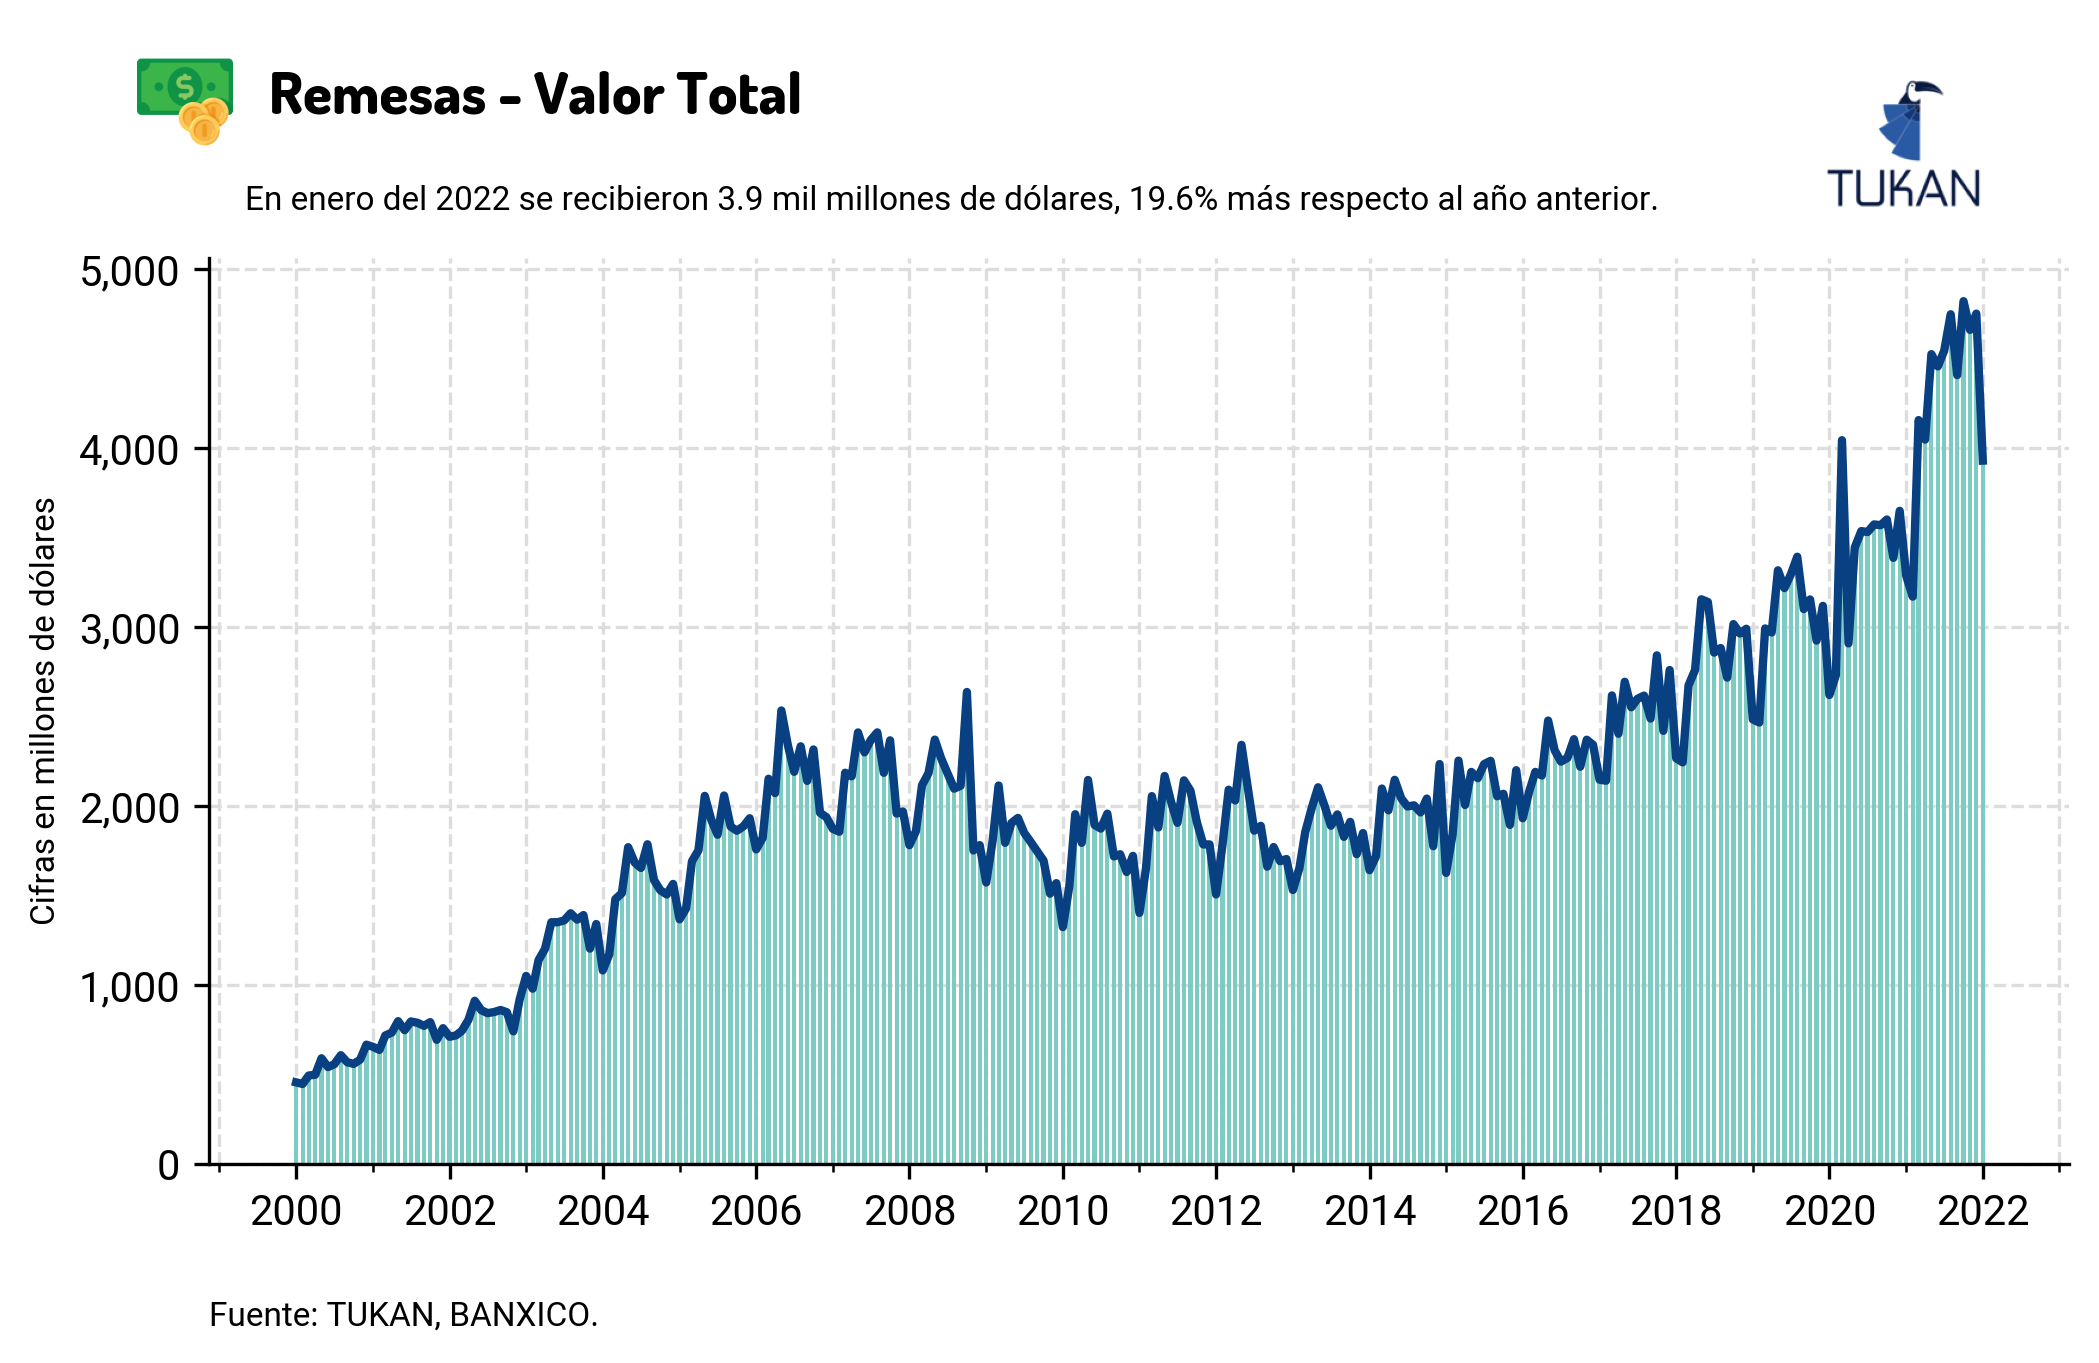

In [22]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(remittances["date"], remittances["amount"], lw=2, zorder=3, color=cmap(0))
ax.bar(remittances["date"], remittances["amount"], zorder=2, width = 20, align='center', alpha=0.99, color=cmap(2))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylabel("Cifras en millones de dólares",
              size=8)

# ax.set_ylim(0)

# Icon
money_icon = image.imread("money.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = remittances['date'].tail(1).dt.strftime("%B del %Y").values[0]
last_value = (remittances['amount'].tail(1).values[0]/1000).round(1)
var_value = (remittances['yoy_amount'].tail(1).values[0]*100).round(1)
if var_value < 0:
    var_dir = 'menos'
else:
    var_dir = 'más'

fig.text(
    0.15,
    1,
    "Remesas - Valor Total",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.14,
    0.92,
    f"En {last_month} se recibieron {last_value} mil millones de dólares, {var_value}% {var_dir} respecto al año anterior.",
    size=8
)
# Add footer
fig.text(0.125, -0.01, "Fuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/remesas_valor_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/remesas_valor_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

plt.savefig(
    "plots/remesas_valor_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Average

(-0.5, 190.5, 190.5, -0.5)

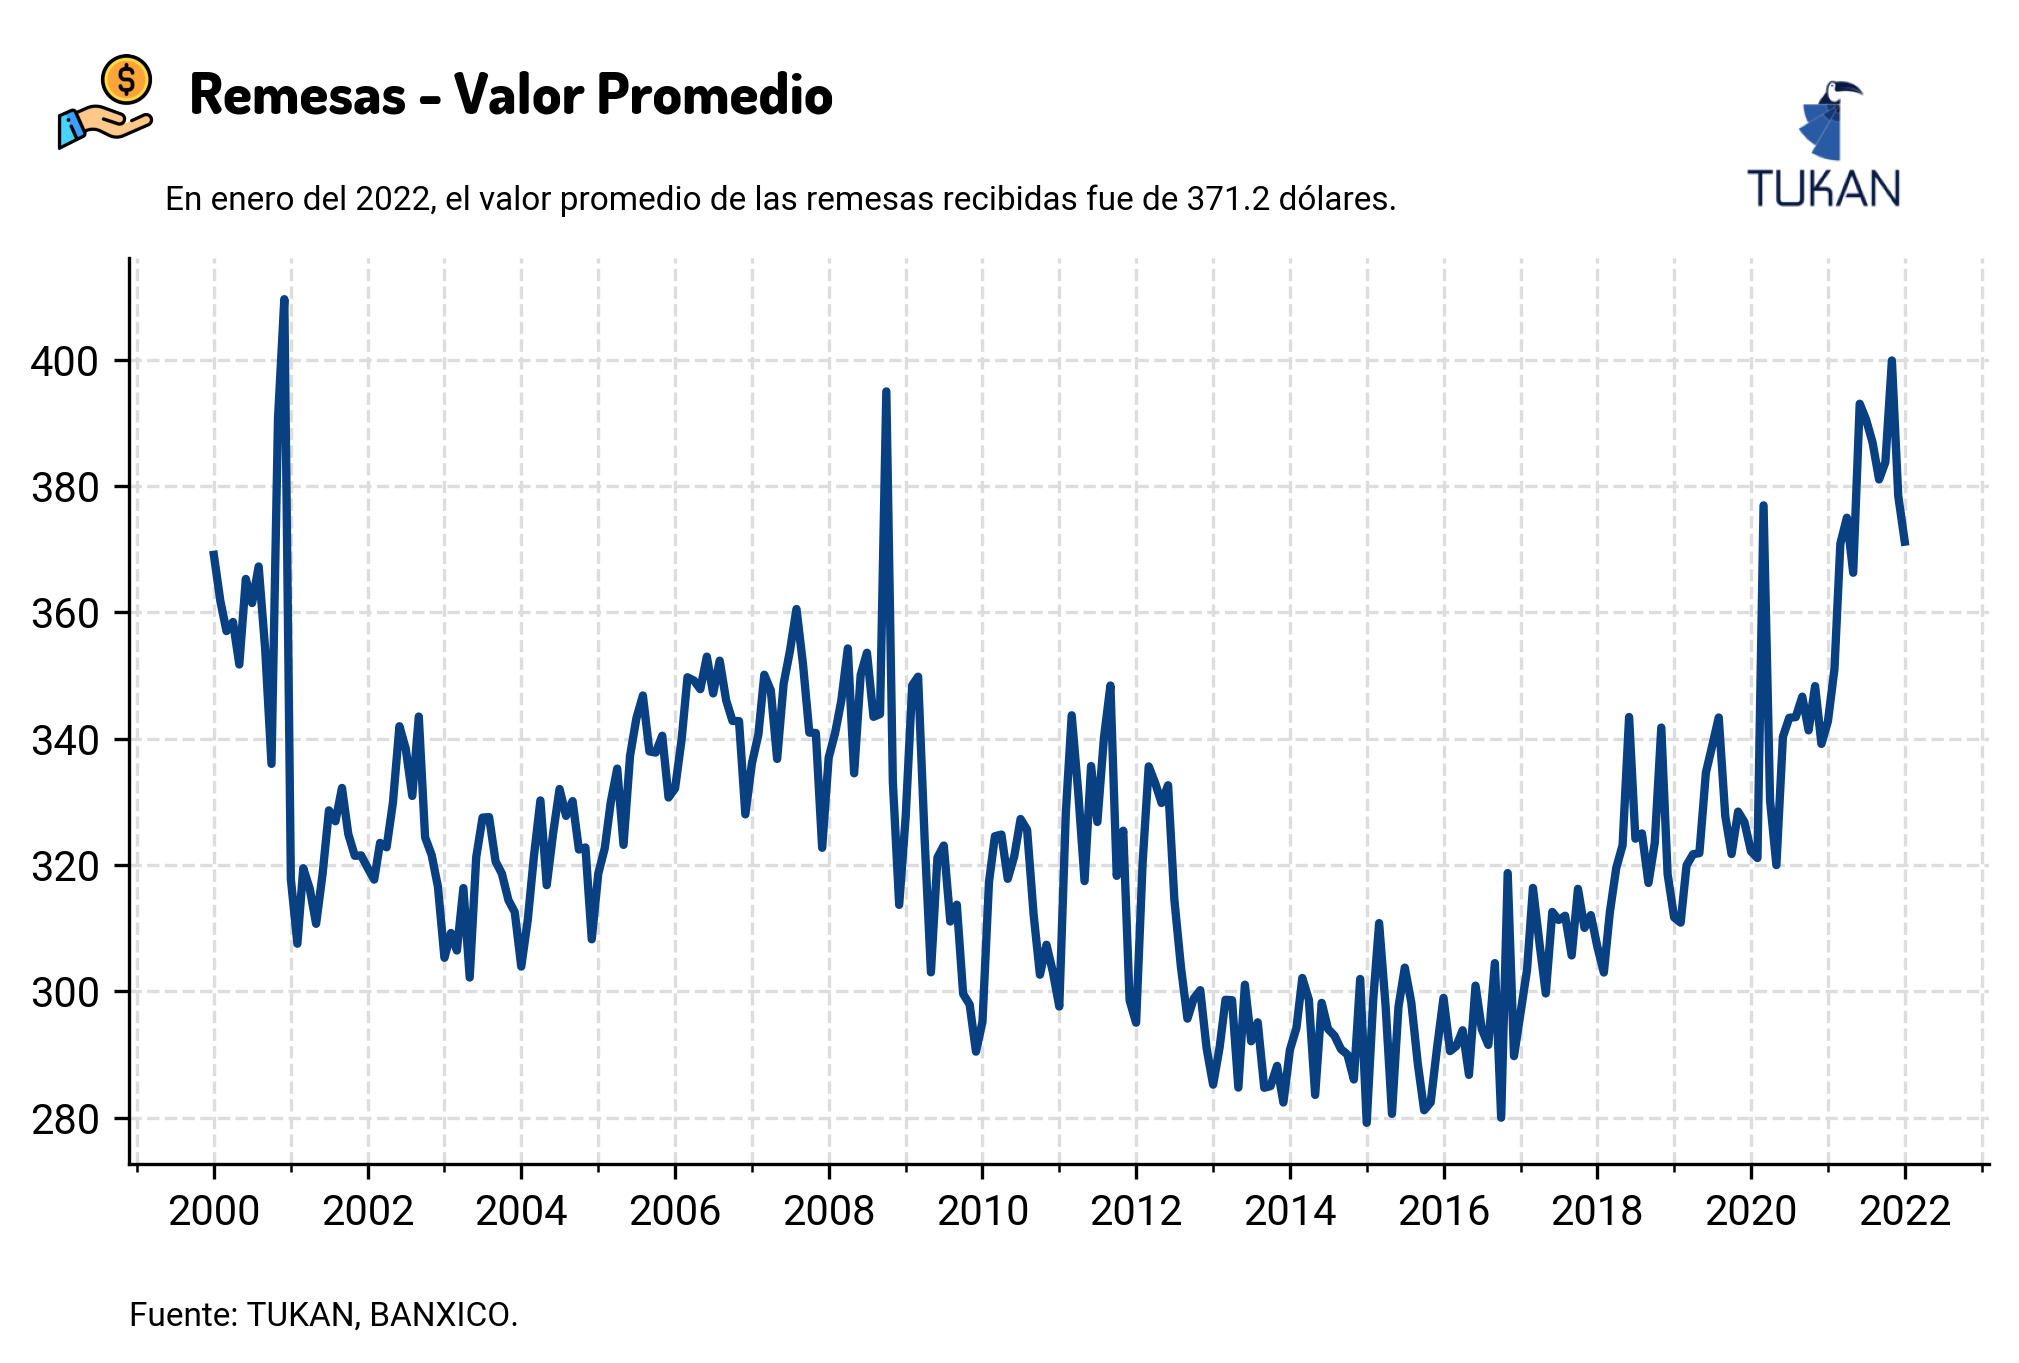

In [23]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(remittances["date"], remittances["avg"], lw=2, zorder=3, color=cmap(0))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.grid(visible=True, which='minor', linestyle='--')

# ax.set_ylim(0)

# Icon
money_icon = image.imread("payment.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = remittances['date'].tail(1).dt.strftime("%B del %Y").values[0]
last_value = (remittances['avg'].tail(1).values[0]).round(1)


fig.text(
    0.15,
    1,
    "Remesas - Valor Promedio",
    size=14,
    weight = "bold",
    family = "Dosis"
)

fig.text(
    0.14,
    0.92,
    f"En {last_month}, el valor promedio de las remesas recibidas fue de {last_value} dólares.",
    size=8
)
# Add footer
fig.text(0.125, -0.01, "Fuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/remesas_promedio_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/remesas_promedio_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/remesas_promedio_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )

## Variation Plots

### Count

(-0.5, 190.5, 190.5, -0.5)

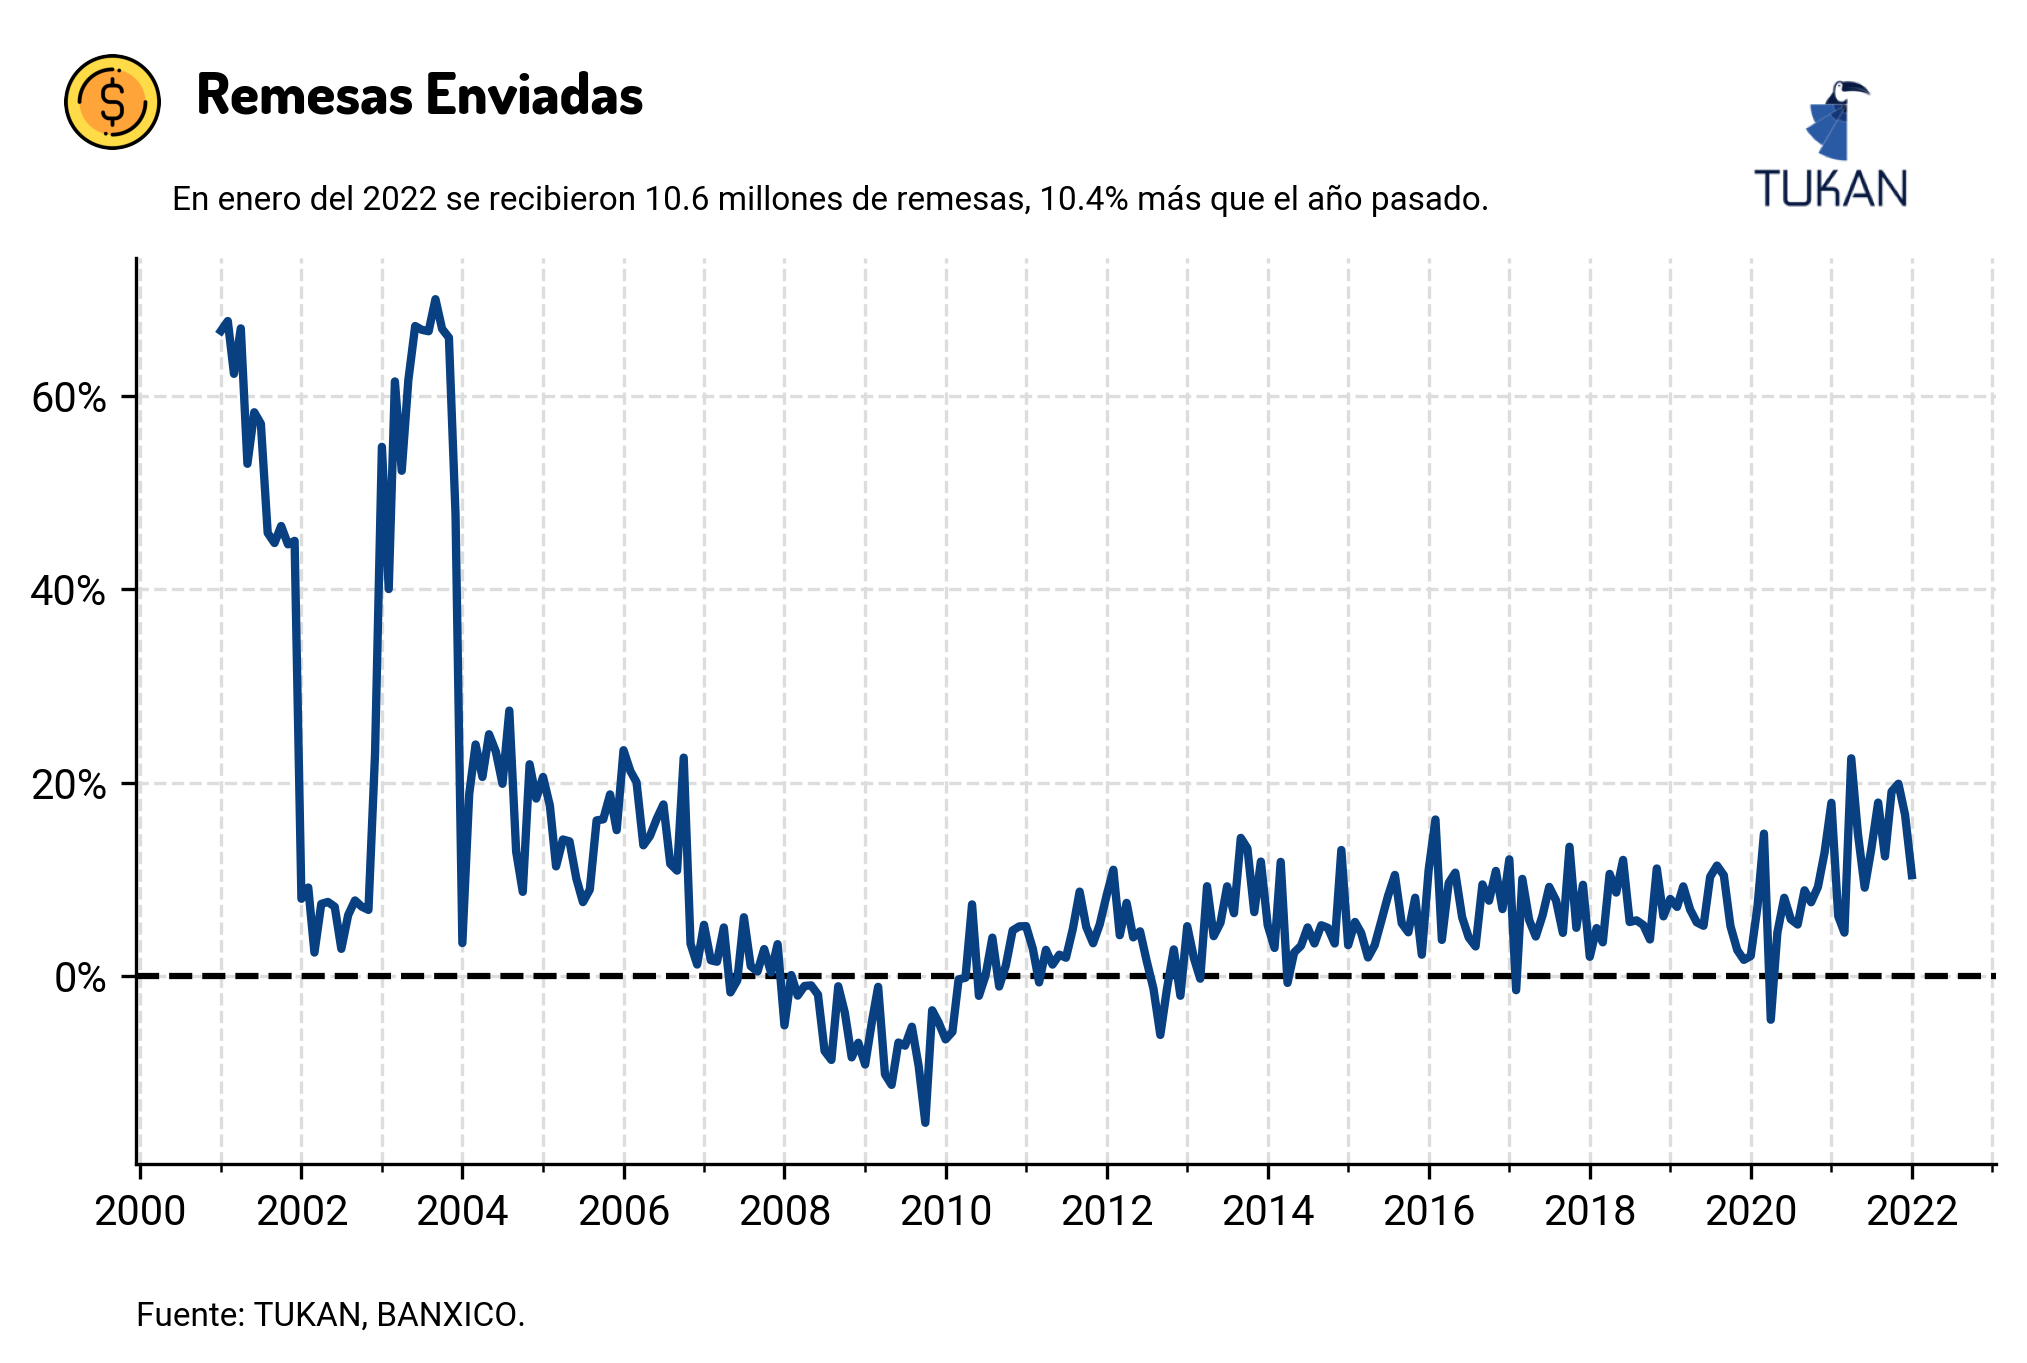

In [24]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(remittances["date"], remittances["yoy_count"], lw=2, zorder=3, color=cmap(0))
ax.axhline(y=0, color='black', linestyle='--', zorder=2)

# ax.bar(remittances["date"], remittances["count"], zorder=2, width = 20, align='center', alpha=0.99, color=cmap(2))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# ax.set_ylim(0)

# Icon
money_icon = image.imread("dollar.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = remittances['date'].tail(1).dt.strftime("%B del %Y").values[0]
last_value = remittances['count'].tail(1).values[0].round(1)
var_value = (remittances['yoy_count'].tail(1).values[0]*100).round(1)

fig.text(
    0.15,
    1,
    "Remesas Enviadas",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.14,
    0.92,
    f"En {last_month} se recibieron {last_value} millones de remesas, {var_value}% más que el año pasado.",
    size=8
)
# Add footer
fig.text(0.125, -0.01, "Fuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/var_remesas_cuenta_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/var_remesas_cuenta_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/var_remesas_cuenta_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )

### Amount

(-0.5, 190.5, 190.5, -0.5)

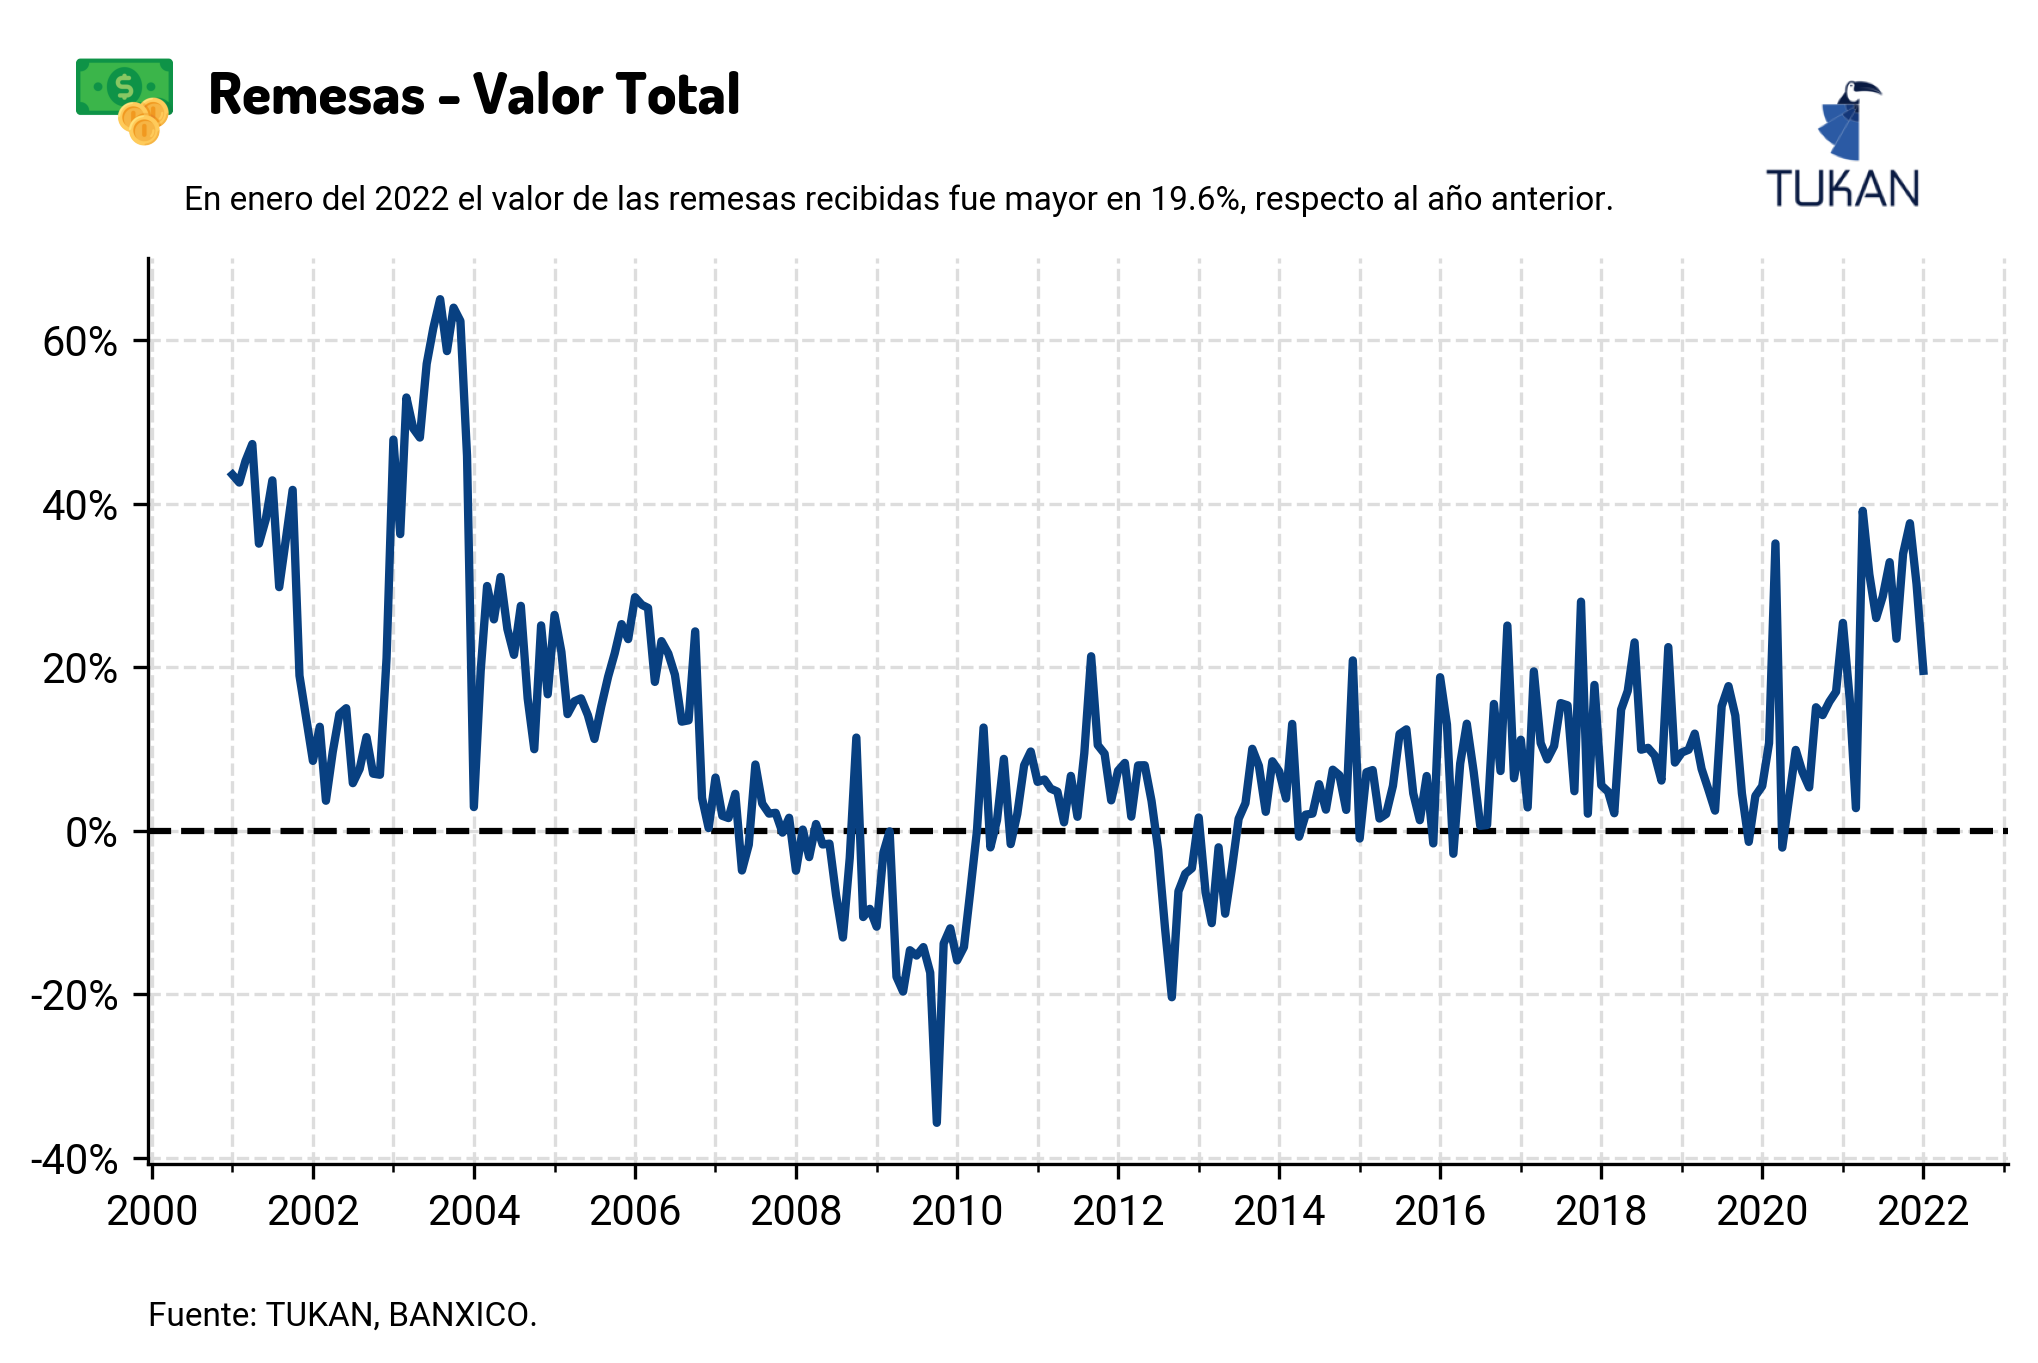

In [25]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(remittances["date"], remittances["yoy_amount"], lw=2, zorder=3, color=cmap(0))
# ax.bar(remittances["date"], remittances["amount"], zorder=2, width = 15, align='center', alpha=0.99, color=cmap(2))
ax.axhline(y=0, color='black', linestyle='--', zorder=2)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# ax.set_ylim(0)

# Icon
money_icon = image.imread("money.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = remittances['date'].tail(1).dt.strftime("%B del %Y").values[0]
last_value = abs(remittances['yoy_amount'].tail(1).values[0]*100).round(1)
if last_value < 0:
    var_tag = 'menor'
else:
    var_tag = 'mayor'
fig.text(
    0.15,
    1,
    "Remesas - Valor Total",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.14,
    0.92,
    f"En {last_month} el valor de las remesas recibidas fue {var_tag} en {last_value}%, respecto al año anterior.",
    size=8
)
# Add footer
fig.text(0.125, -0.01, "Fuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/var_remesas_valor_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/var_remesas_valor_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/var_remesas_valor_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )

### Average

(-0.5, 190.5, 190.5, -0.5)

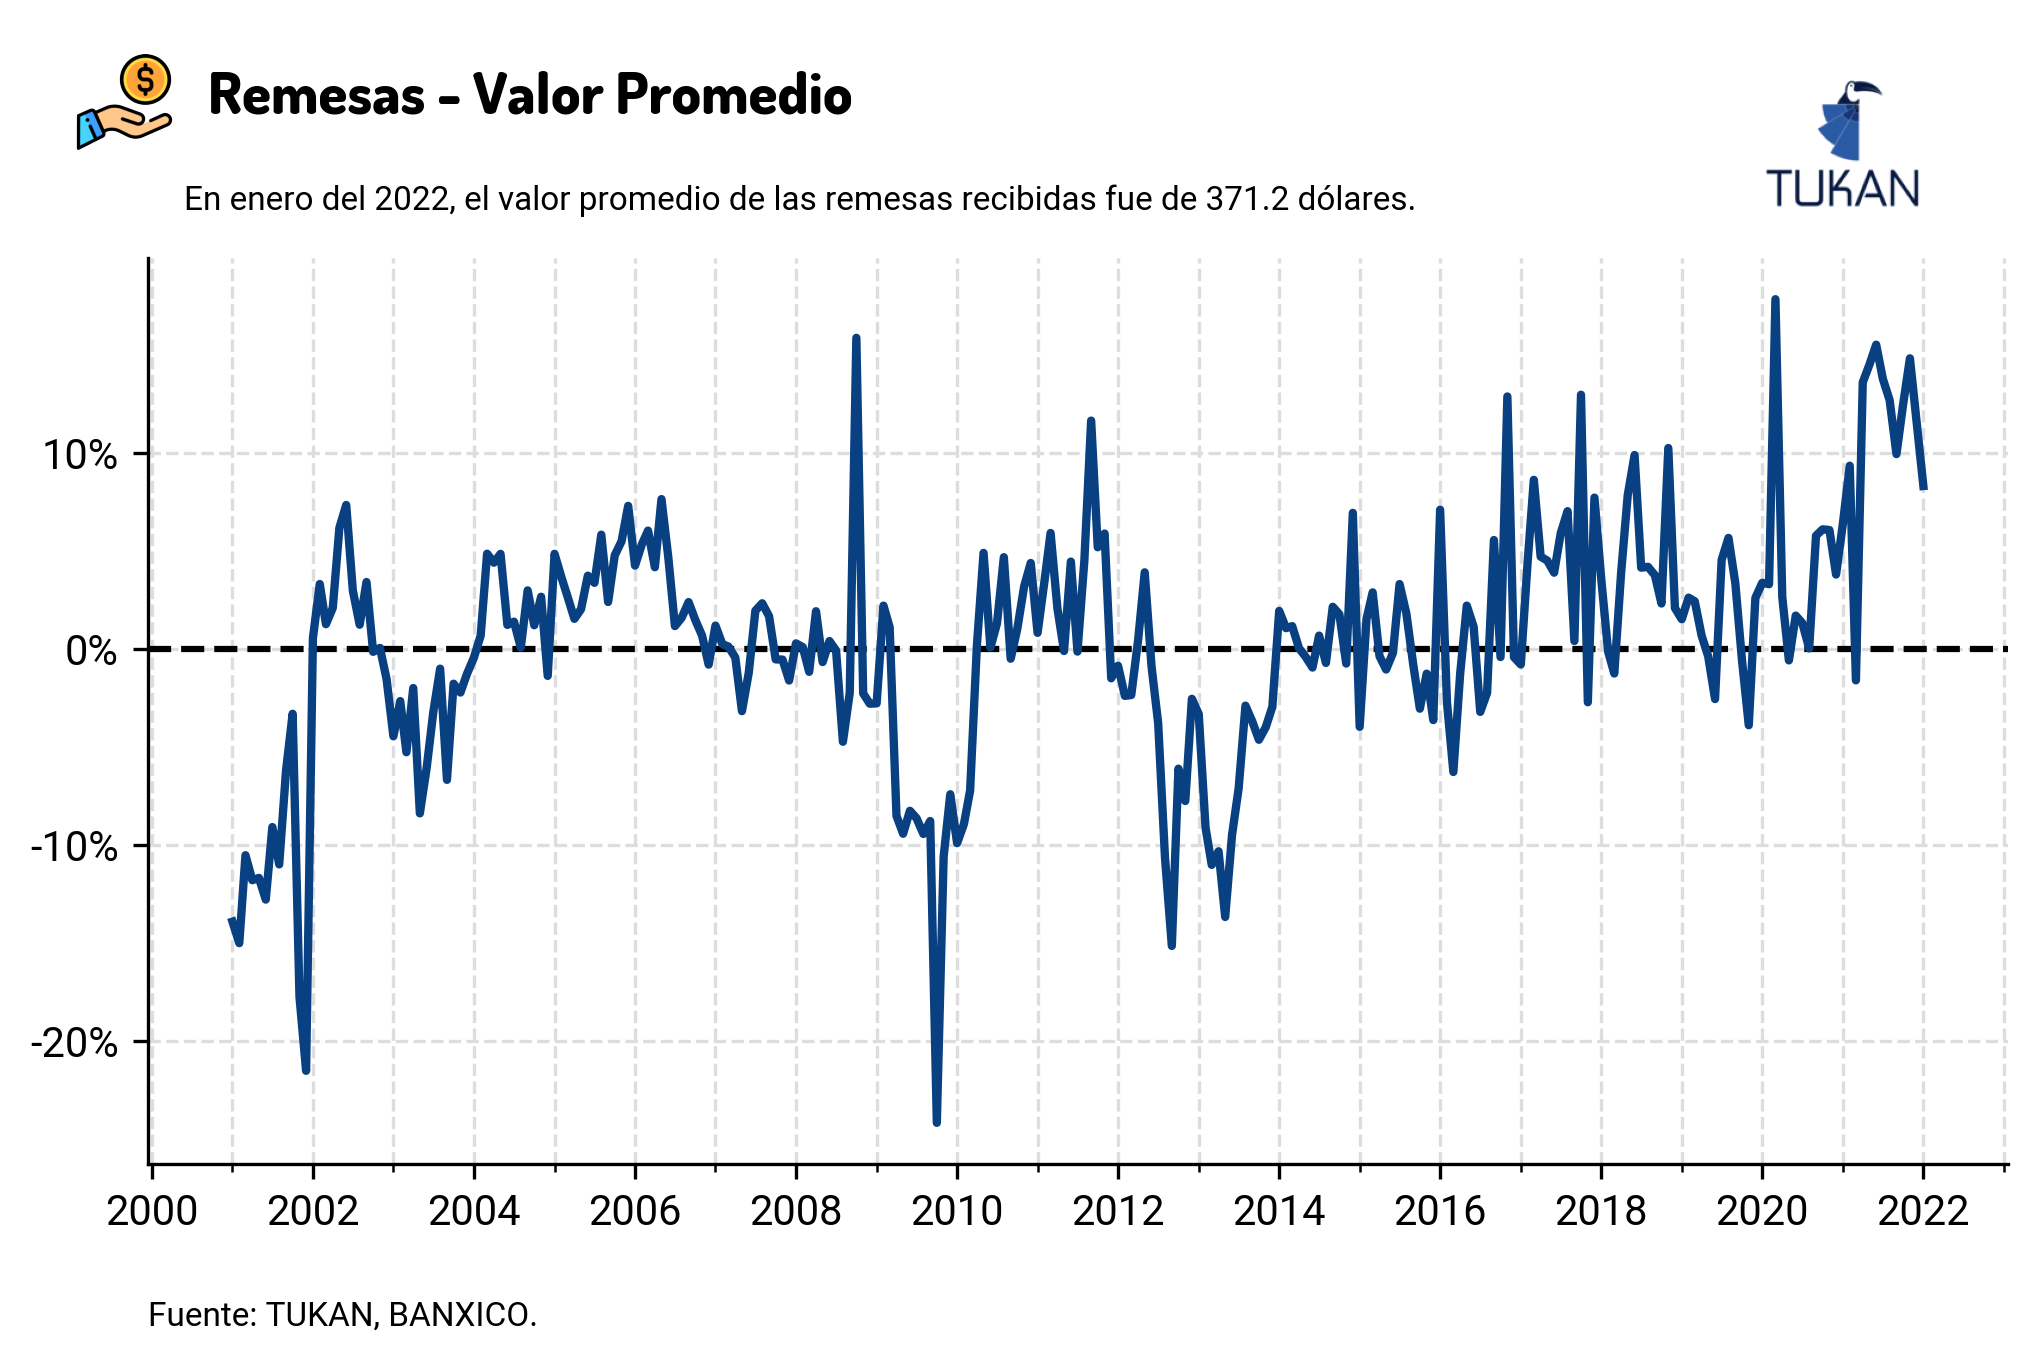

In [26]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(remittances["date"], remittances["yoy_avg"], lw=2, zorder=3, color=cmap(0))
ax.axhline(y=0, color='black', linestyle='--', zorder=2)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# ax.set_ylim(0)

# Icon
money_icon = image.imread("payment.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = remittances['date'].tail(1).dt.strftime("%B del %Y").values[0]
last_value = (remittances['avg'].tail(1).values[0]).round(1)


fig.text(
    0.15,
    1,
    "Remesas - Valor Promedio",
    size=14,
    weight = "bold",
    family = "Dosis"
)

fig.text(
    0.14,
    0.92,
    f"En {last_month}, el valor promedio de las remesas recibidas fue de {last_value} dólares.",
    size=8
)
# Add footer
fig.text(0.125, -0.01, "Fuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/var_remesas_promedio_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/var_remesas_promedio_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/var_remesas_promedio_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )

## Month Bar Plots

In [27]:
month_plot = remittances[remittances['date'].dt.month == 1].reset_index(drop=True)
# month_plot = month_plot.tail(6)
month_plot

,date,transaction_type__ref,transaction_type,count,amount,avg,yoy_count,yoy_amount,yoy_avg
0,2000-01-01,67ab6809f8707c4,Todas las transacciones,1.236025,456.2456,369.123278,NaN,NaN,NaN
1,2001-01-01,67ab6809f8707c4,Todas las transacciones,2.061018,654.9820,317.795381,0.667457,0.435591,-0.139054
2,2002-01-01,67ab6809f8707c4,Todas las transacciones,2.225202,711.0430,319.540878,0.079662,0.085592,0.005493
3,2003-01-01,67ab6809f8707c4,Todas las transacciones,3.443376,1051.2547,305.297679,0.547444,0.478469,-0.044574
4,2004-01-01,67ab6809f8707c4,Todas las transacciones,3.559883,1081.8635,303.904229,0.033835,0.029116,-0.004564
5,2005-01-01,67ab6809f8707c4,Todas las transacciones,4.292145,1367.5563,318.618383,0.205698,0.264075,0.048417
6,2006-01-01,67ab6809f8707c4,Todas las transacciones,5.293970,1758.3057,332.133673,0.233409,0.285728,0.042418
7,2007-01-01,67ab6809f8707c4,Todas las transacciones,5.573122,1872.9292,336.064633,0.052730,0.065190,0.011835
8,2008-01-01,67ab6809f8707c4,Todas las transacciones,5.286971,1781.6996,336.998179,-0.051345,-0.048710,0.002778
9,2009-01-01,67ab6809f8707c4,Todas las transacciones,4.801134,1572.9751,327.625744,-0.091893,-0.117149,-0.027812


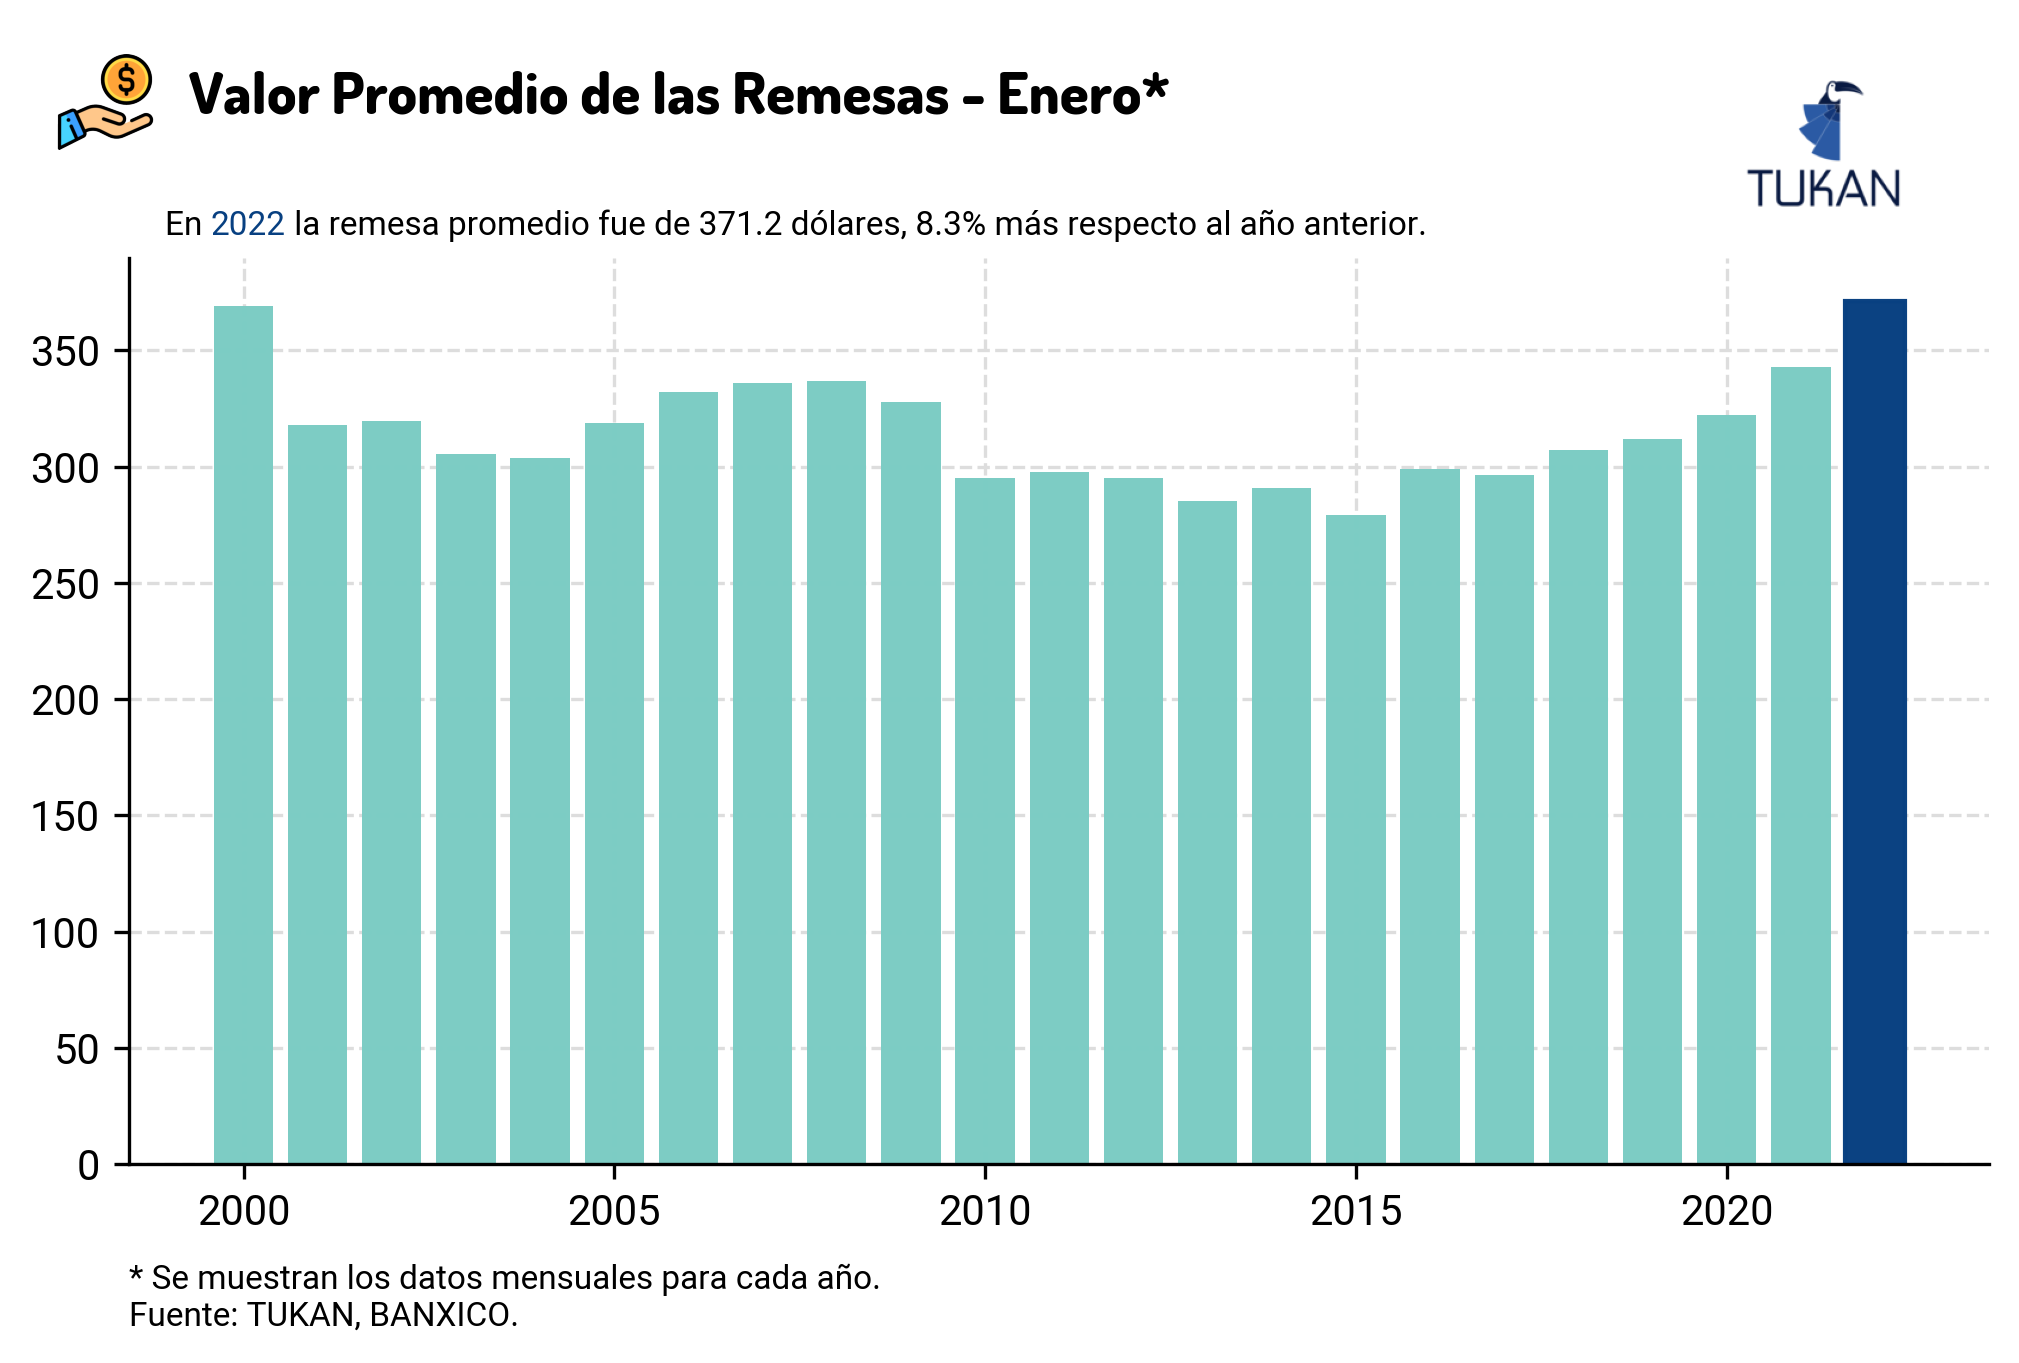

In [28]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)

barlist = ax.bar(month_plot["date"].dt.year, month_plot["avg"], zorder=2, align='center', alpha=0.99, color=cmap(2))
barlist[-1].set_color(cmap(0))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylim(0)

# Icon
money_icon = image.imread("payment.png")
money_ax = fig.add_axes([0.09, .97, 0.05, 0.08], zorder=1)
money_ax.imshow(money_icon)
money_ax.axis("off")

# aux vars for subtitle
last_month = month_plot['date'].tail(1).dt.strftime("%B").values[0]
last_year = month_plot['date'].tail(1).dt.strftime("%Y").values[0]
last_value = month_plot['avg'].tail(1).values[0].round(1)
var_value = (month_plot['yoy_avg'].tail(1).values[0]*100).round(1)
if var_value < 0:
    var_dir = 'menos'
else:
    var_dir = 'más'
    
fig.text(
    0.15,
    1,
    f"Valor Promedio de las Remesas - {last_month.capitalize()}*",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig_text(
    0.14,
    0.92,
    s=f"En <{last_year}> la remesa promedio fue de {last_value} dólares, {var_value}% {var_dir} respecto al año anterior.",
    highlight_textprops=[{"color":cmap(0)}],
    # weight = "bold",
    size=8
)

# fig_text(
#     x = 0.1, y = 1.07,
#     s = "Búsquedas de guacamole en <México> y <Estados Unidos>",
#     highlight_textprops=[{"color":cmap(0)}, {"color":cmap(2)}],
#     size=18,
#     weight = "bold",
#     family = "Dosis"
# )


# Add footer
fig.text(0.125, -0.01, "* Se muestran los datos mensuales para cada año.\nFuente: TUKAN, BANXICO.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/var_remesas_cuenta_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/var_remesas_cuenta_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

plt.savefig(
    "plots/mes_remesas_promedio_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)